<a href="https://colab.research.google.com/github/namigabbasov/Text-Analysis-and-NLP/blob/main/Text_Classification_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification with BERT**

In [ ]:
!pip install wordcloud
!pip install xgboost lightgbm --quiet
!pip install transformers torch
!pip install datasets
!pip install evaluate
!pip install contractions
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
   ━━━

In [ ]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import time

from wordcloud import WordCloud


import nltk
nltk.download('punkt')
nltk.download('stopwords')

nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

from sklearn.preprocessing import LabelEncoder

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split

import numpy as np
import evaluate

import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Load Data

Link to download data: [link text](https://www.kaggle.com/datasets/namigabbasov/consumer-complaint-dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Projects /Projects-Fall-2024/ConsumerVoice/complaints.csv'
df = pd.read_csv(file_path)
df= df.sample(frac=0.01, random_state=42)  # using only 1 percent of data because of high computation

## Explore Data

In [ ]:
df["Product"].value_counts()

,count
Product,
"Credit reporting, credit repair services, or other personal consumer reports",8138
Credit reporting or other personal consumer reports,3688
Debt collection,2608
Mortgage,1194
Credit card or prepaid card,1077
Checking or savings account,1011
Credit card,504
Student loan,450
"Money transfer, virtual currency, or money service",432


<Axes: ylabel='count'>

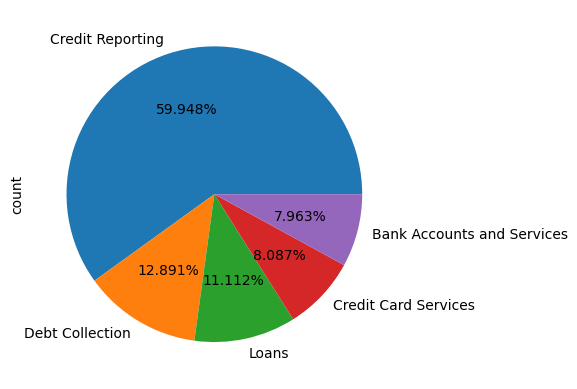

In [ ]:
df["product_5"].value_counts().head(10).plot(kind="pie", autopct="%.3f%%")

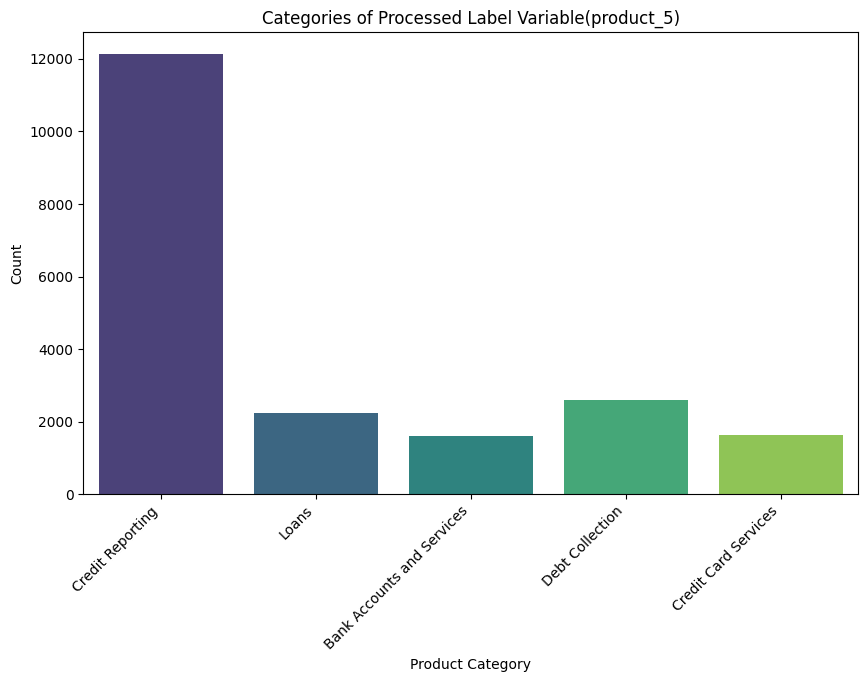

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="product_5", palette="viridis")
plt.title("Categories of Processed Label Variable(product_5)")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
product_5,0
narrative,0
Product,0
Date received,0
Sub-product,523
Issue,0
Sub-issue,2293
Company,0
State,62


In [ ]:
df["narrative"].iloc[2000]

"XXXX, XXXX XXXX XXXX SOC SEC # XXXX DOB XX/XX/XXXX ADDRESS XXXX XXXX XXXX, XXXX, FL XXXX ATTENTION DISPUTE DEPARTMENT TODAYS DATE : XX/XX/XXXX This serves to notify you on the inaccurate information on my credit report as per your file. I have sent this letter via registered mail for purposes of formal escalation in the appropriate courts of law should the need arise. \nRecently, I've been denied in my application for ( mortgage, car loan, credit card, health insurance, employment ) in Florida XXXXUpon closer look, this was due to inaccurate information on credit report ; mine. My Florida id and social security card was stolen. I have been disputing this charge and have proved that it was a fraudulent account I have also included a copy of the police report. I've been unnecessarily embarrassed by this oversight on your part or maybe your credit reporter 's part. The erroneous information below is not only degrading or defamatory. It has also damaged my good credit standing, prevented 

In [ ]:
df = df[['product_5', 'narrative']]
pd.set_option('display.max_colwidth', None)
df.head()

,product_5,narrative
552588,Credit Reporting,"I have asked XXXX XXXX and experian to have XXXX XXXX XXXX, XXXX XXXX XXXX and XXXX XXXX XXXX to provide proof of contract with my signature on it stating I owe these collection companys money and if proof of contract is not provided to have them deleted immediately"
487309,Credit Reporting,"This is my fourth endeavor to tell you that I am a victim of identity theft and I complain to question specific records in my document coming about because of the wrongdoing. The records I am questioning connect with no exchanges acquiring any possession of goods, services, or money that I have made or authorized. Assuming no one cares, either way, block the noteworthy of any information in my credit record that came about due to alleged fraud or extortion. \nXXXX XXXX XXXX XXXX, HI XXXX ; XXXXXXXX XXXX XXXXXXXX Balance : {$1400.00} ; XXXX XXXX XXXX XXXX Balance : {$3300.00} ; XXXX XXXX XXXX XXXX XXXX XXXX XXXX {$12000.00} ; XXXXXXXX XXXX XXXXXXXX Balance : {$11000.00} ; XXXXXXXX XXXX XXXX XXXX XXXXXXXX Balance XXXX {$6000.00} XXXX XXXX XX/XX/2021 ;"
1549092,Loans,I took out a small loan which I thought was a payday type of loan for {$1200.00}. \n\nI was approved over the phone. \n\nThey credit my bank account on XX/XX/XXXX for {$1200.00}. \n\nI thought that I would only need to pay 4 payments of {$340.00} to cover the cost of the loan and interest. They were not clear with the loan agreement.\n\nI made 4 payments of {$340.00} on XX/XX/XXXX XX/XX/XXXX XX/XX/XXXX XX/XX/XXXX This is a total payment of {$1300.00} for a {$1200.00} loan ( XXXX in interest ). \n\nThey attempted a 5th payment of XXXX on XX/XX/XXXX which I do not authorize and was surprised to see hit my account since I thought I had paid off this loan. \n\nI immediately called them to ask them about this and they told me that per the loan agreement that I owe them 20 payments of {$340.00}. This amount of payments was never disclosed to me over the phone when I was approved for the loan or thereafter. I would never have agreed to 20 payments of {$340.00} with them for a {$1200.00} loan. That is beyond predatory or reasonable. \n\nAfter getting on the phone with them I tried to access my account with them on their website and I entered my email address and last four of my social and still could not log in to see any documentation regarding my loan. I have no documentation nor did I ever receive documentation prior to agreeing to this loan. The approval process was done over the phone. \n\nI am filing this complaint because they are not being upfront with customers about loan terms and agreements and fees and they are being predatory in charging excessive interest rates. Furthermore they are preying upon poor people and exploiting American consumers with these practices.
1359447,Loans,"Wells Fargo is creating false statements and including them on formal documents. They sent me an escrow analysis, which is a formal legal document, during the 1st week of XX/XX/XXXX and on the document they wrote that I had a XXXX overage but that they would not send it to me because I was delinquent. \nThat statement that I was delinquent was a false statement and by putting it in the document Wells Fargo is making it an official record. The Facts are my payments are not delinquent, and have not been. Here are the dates that Wells Fargo has cashed my monthly ACH transfers. \nXXXX {$850.00} XXXX {$850.00} XXXX {$850.00} XXXX {$850.00} XXXX {$850.00}XX/XX/XXXX {$850.00}XX/XX/XXXX {$850.00} fee added XXXX ( XXXX )XX/XX/XXXX {$850.00}XX/XX/XXXX {$850.00} This Loan is a VA Loan and the VA has made it very clear to Wells Fargo that my payments are not late until after the XXXX of each month. Yet I am receiving many harassing calls from Wells Fargo. They call over and over again and then when I dont answer they dont leave any message. In addition, Wells Fargo monthy statement they send me each month clearly says that if I should send payment after the XXXX to ad

In [ ]:
# Define the mapping
category_mapping = {
    'Credit Reporting': 0,
    'Debt Collection': 1,
    'Loans': 2,
    'Credit Card Services': 3,
    'Bank Accounts and Services': 4
}

# Recode the 'product_5' variable
df['product_5'] = df['product_5'].map(category_mapping)
df = df.rename(columns={'product_5': 'labels'})

In [ ]:
df.columns

## Text Preporcessing

In [ ]:
def preprocess_text(text):
    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Remove sequences of two or more 'X's
    text = re.sub(r'\bX{2,}\b', '', text)

    # Lowercase text
    text = text.lower()

    # remove newlines
    text = re.sub(r'\n', ' ', text)

    # Mask number amounts like $1400.00 with <amount>
    text = re.sub(r'\{\$[0-9,\.]+\}', '<amount>', text)

    # replace dates with <date>
    text = re.sub(r'\d{2}/\d{2}/\d{4}', '<date>', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing function directly to 'narrative' column
df['narrative'] = df['narrative'].apply(preprocess_text)


In [ ]:
df = df[['labels', 'narrative']]
pd.set_option('display.max_colwidth', None)
df.head()

,labels,narrative
552588,0,asked experian provide proof contract signature stating owe collection company money proof contract provided deleted immediately
487309,0,fourth endeavor tell victim identity theft complain question specific record document coming wrongdoing record questioning connect exchange acquiring possession good service money made authorized assuming one care either way block noteworthy information credit record came due alleged fraud extortion hi balance amount balance amount amount balance amount balance amount
1549092,2,took small loan thought payday type loan amount approved phone credit bank account amount thought would need pay payment amount cover cost loan interest clear loan agreement made payment amount total payment amount amount loan interest attempted th payment authorize surprised see hit account since thought paid loan immediately called ask told per loan agreement owe payment amount amount payment never disclosed phone approved loan thereafter would never agreed payment amount amount loan beyond predatory reasonable getting phone tried access account website entered email address last four social still could log see documentation regarding loan documentation ever receive documentation prior agreeing loan approval process done phone filing complaint upfront customer loan term agreement fee predatory charging excessive interest rate furthermore preying upon poor people exploiting american consumer practice
1359447,2,well fargo creating false statement including formal document sent escrow analysis formal legal document st week document wrote overage would send delinquent statement delinquent false statement putting document well fargo making official record fact payment delinquent date well fargo cashed monthly ach transfer amount amount amount amount amount amount amount fee added amount amount loan va loan va made clear well fargo payment late month yet receiving many harassing call well fargo call answer leave message addition well fargo monthy statement send month clearly say send payment add late fee well completely aware late month explained well veteran administration well also warned write addition loan agreement align va guideline yet month harass create false document past year complained well charging escrow analysis deny yet time past year send back overage twice repay escrow money move area type falsification indicative corrupt experience well fargo moreover well saying raising monthly amount increase amount one week later receive overage check amount logic escape first falsely claim delinquency say enough escrow support amount increase send overage check worth year worth increase highly unprofessional suspect lastly normal procedure shortage mortgagee usually option sending shortage amount maintain rate well include option send pay fact took money escrow claiming excess claimed insufficient fund available maintain escrow
1524148,4,account chime bank last year without problem last year signed chime secured credit card help raise credit score use checking account transfer money use credit card bill pay problem last year tried log account received small notification screen saying account closed thought error contact thought surely mistake since notified advance account closure thought try log tomorrow see happens tried xxxxhree day row sent email chime received email stating account closed following reason account comply internal policy member agreement explanation howwhy account compliance closure letter informed money account check would mailed within next day insanity wait long money belongs also informed eligible refund fund without explanation sent email received response basically stated due security reason email email chime file assist problem went ahead sent email email address file day still heard anything response sent another email today tried call customer service number since phone number registered account get automated response saying account closed need email assistance

In [ ]:
# Split into training and test sets - we can do val as well - into three sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['narrative'], df['labels'], test_size=0.2, random_state=42)

# Display split data information
print(f"Number of training examples: {len(train_texts)}")
print(f"Number of test examples: {len(test_texts)}")

Number of training examples: 16184
Number of test examples: 4047


## BERT Tokenizer

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text data
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors="pt")

# tokenize training and test data
train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

# Check if tokenization works correctly
print(train_encodings.keys())  # input_ids, token_type_ids, and attention_mask will be keys
print(train_encodings['input_ids'].shape)  # check shape

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([16184, 512])


## Pytorch Tensor

In [ ]:
# necessary to put in torch tensor
class Dataset(torch.utils.data.Dataset): # inherit dataset from pytoch
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # access the encodings and labels for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# we finally train and test datasets for Bert
train_dataset = Dataset(train_encodings, train_labels.tolist())
test_dataset = Dataset(test_encodings, test_labels.tolist())

# Check first data point to ensure the dataset is created correctly
print(train_dataset[0])

{'input_ids': tensor([  101,  3531,  6519, 24014,  7318,  4651,  2081,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

## Load BERT

In [ ]:
# get number of unique labels
num_labels = df['labels'].nunique()

# load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# check model
print(model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Train BERT

In [ ]:
# Load accuracy metric from the evaluate library
accuracy_metric = evaluate.load("accuracy")

# Define a custom compute_metrics function to calculate accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the index of the highest logit (predicted class)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}  # Return accuracy as a metric

# Define training arguments with evaluation and save strategies matching
training_args = TrainingArguments(
    output_dir='./results',                # Output directory for model checkpoints
    num_train_epochs=3,                    # Number of epochs
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    warmup_steps=500,                      # Warmup steps for learning rate scheduler
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='./logs',                  # Directory for storing logs
    logging_steps=10,                      # Log every 10 steps
    evaluation_strategy="steps",           # Evaluate every eval_steps
    eval_steps=100,                        # Evaluate every 100 steps
    save_strategy="steps",                 # Save the model every eval_steps
    save_steps=100,                        # Save every 100 steps (same as eval_steps)
    load_best_model_at_end=True,           # Load the best model at the end based on validation loss
    metric_for_best_model="accuracy",      # Use accuracy to determine the best model
)

# Define the Trainer, passing the model, training arguments, datasets, and compute_metrics function
trainer = Trainer(
    model=model,                           # BERT model
    args=training_args,                    # Training arguments
    train_dataset=train_dataset,           # The training dataset
    eval_dataset=test_dataset,             # The validation/test dataset
    compute_metrics=compute_metrics        # Function to calculate accuracy
)

# Start training
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
100,1.033000,1.005188,0.650852
200,0.858400,0.740880,0.753150
300,0.530700,0.592830,0.812207
400,0.472700,0.498532,0.847541
500,0.353800,0.491712,0.852236


In [ ]:
metrics = trainer.evaluate()
print(metrics)

In [ ]:
# Save model and tokenizer
model.save_pretrained("./results/best_model")
tokenizer.save_pretrained("./results/best_model")

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained("./results/best_model")
tokenizer = BertTokenizerFast.from_pretrained("./results/best_model")

# Create a pipeline for text classification
my_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [ ]:
my_model("I am writing to express my dissatisfaction and frustration with the service I have received regarding my credit card account. Over the past few months, I have encountered multiple issues that need immediate attention and resolution.")

## Next Steps


*   Experiment with Hyperparameters
*   Parameter-Efficient Fine-Tuning

